# Get data

In [1]:
import warnings 
import numpy as np

warnings.filterwarnings("ignore")

## Retrieve the data from S3

In [2]:
from common_tools.aws.s3 import S3Client
import pandas as pd 
s3_client = S3Client()
data_path = s3_client.download_file('seloger-data-developers-dev','alaborde/data/data_query_20200220.csv')
data = pd.read_csv(data_path)

## Retrieve the ref_geo from S3

In [3]:
from common_tools.aws.s3 import S3Client
import pandas as pd
s3_client = S3Client()
ref_geo_path = s3_client.download_file('seloger-data-developers-dev','alaborde/data/ref_geo.csv')
ref_geo = pd.read_csv(ref_geo_path)

# Prepare data

In [4]:
data_prep = data[['idannonce','cp','ville','codeinsee','descriptif_fr',
             'px', 'surface','annee_construct','nb_pieces', 'latitude', 'longitude']].copy()

## Ads localization

### Geo mapper CP --> City

In [5]:
key_city = ['city_name','city_id','city_code_insee_sl']
geomap_cp = ref_geo.drop_duplicates(subset=key_city).dropna(subset=key_city)[key_city]
geomap_cp = geomap_cp.rename(columns={'city_code_insee_sl': 'codeinsee'})

In [6]:
data_prep_code_insee = data_prep.merge(geomap_cp, how='left',on=['codeinsee'])
data_prep_code_insee = data_prep_code_insee.rename(columns={
    "city_name": "city_name_by_code_insee",
    "city_id": 'city_id_by_code_insee'
})

### Project in Polygon

In [7]:
import sys
sys.path.append('/home/jeanchristophe/codeFolder/sl_data-science-models/pricemap/src')
sys.path.append('/home/jeanchristophe/codeFolder/sl_data-science-models/priceml/src')
from pricemap.localization.looker import PolygonLookup
from pricemap.localization.utils import looker_dict, build_geo_mapper
from pricemap.filter.filters import lat_long_filter

iris_dict, _, _ = looker_dict(ref_geo)
iris_lookup = PolygonLookup(iris_dict)

In [8]:
def localize(df: pd.DataFrame,
             looker_iris: PolygonLookup,
             ref_geo: pd.DataFrame) -> pd.DataFrame:
    df_to_localize = df.copy()
    df_to_localize.index.name = 'index'
    geo_map_iris, _, geo_map_city = build_geo_mapper(ref_geo)
    # Get dataframe with lat/lon information
    df_with_latlon = df_to_localize.dropna(subset=['latitude', 'longitude']).copy()

    # Look at the IRIS level
    iris_id_from_latlon = looker_iris.lookup(df_with_latlon[['latitude', 'longitude']])
    # Get projection table iris_id => dataframe index
    index_to_id_iris = iris_id_from_latlon.to_frame().dropna()
    index_to_id_iris.columns = ['iris_id']
    index_to_id_iris.index.name = 'index'
    # Merge dataframe with district id
    dataframe_with_idiris = df_to_localize.merge(index_to_id_iris, how='right', on='index')
    # And add the geo info
    geo_map_iris['iris_id'] = geo_map_iris['iris_id'].astype(int)
    dataframe_with_idiris = dataframe_with_idiris.merge(geo_map_iris, how='left', on='iris_id')
    return dataframe_with_idiris

In [9]:
data_prep_code_insee_filt = lat_long_filter(data_prep_code_insee, 'latitude', 'longitude', False)
data_loc = localize(data_prep_code_insee_filt, iris_lookup, ref_geo)

In [10]:
geomap_cp_bis = geomap_cp.rename(columns={"codeinsee": "city_code_insee_sl",
                                         'city_id': 'city_id_from_latlon'})
data_loc = data_loc.merge(geomap_cp_bis, how='left', on=['city_code_insee_sl'])

In [11]:
data_localized = pd.concat([data_loc, data_prep_code_insee_filt], sort=False).drop_duplicates(subset=['idannonce'], keep='first')

In [12]:
districts_mapper = ref_geo.dropna(subset=['districts_id','districts_name']).drop_duplicates(subset=['districts_id','districts_name'])
districts_mapper = districts_mapper[['districts_id','districts_name']].copy()

In [13]:
data_localized_keep = data_localized[(data_localized['city_id_by_code_insee'] ==data_localized['city_id_from_latlon'])
              | (data_localized['city_id_from_latlon'].isna())]
data_localized_keep = data_localized_keep.merge(districts_mapper, how='left', on=['districts_id'])
data_localized_keep = data_localized_keep.drop(columns=['city_name', 'city_id_from_latlon','iris_id',
                                                       'department_id','region_id','country_id'])
data_loc = data_localized_keep.rename(columns={
    "city_name_by_code_insee": 'city_name',
    'city_id_by_code_insee': 'city_id',
    
}).copy()

In [14]:
data_loc

,idannonce,cp,ville,codeinsee,descriptif_fr,px,surface,annee_construct,nb_pieces,latitude,longitude,city_name,city_id,districts_id,city_code_insee_sl,districts_name
0,153921147,83270,Saint Cyr sur Mer,830112.0,Les Lecques - en première ligne - proche mer e...,300000.0,37.70,NaN,2.0,43.179253,5.688592,Saint-Cyr-sur-Mer,35973.0,46103.0,830112.0,Les Lecques-Banette-Bourrasque-Pradeaux
1,149065527,83700,Saint Raphael,830118.0,L'agence WF KING de Valescure vous propose dan...,277000.0,55.00,2018.0,2.0,43.418758,6.796278,Saint-Raphaël,35979.0,46123.0,830118.0,Boulouris
2,146323453,78610,Saint-Leger-en-Yvelines,780562.0,Venez découvrir à mes côtés ce bien rare et at...,170000.0,57.00,1800.0,3.0,48.721718,1.764741,Saint-Léger-en-Yvelines,34117.0,NaN,780562.0,NaN
3,152749001,93140,Bondy,930010.0,Situé dans le nouvel éco quartier de Bondy en ...,213218.0,43.00,NaN,2.0,48.903725,2.485260,Bondy,38353.0,47200.0,930010.0,Le Saule Blanc
4,154493689,69100,Villeurbanne,690266.0,"Château Gaillard, en étage élevé d'une future ...",498000.0,95.82,2021.0,4.0,45.773087,4.889020,Villeurbanne,30327.0,44571.0,690266.0,Les Poulettes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,152667559,69330,Meyzieu,690282.0,Appartement 4 pièces d'environ 66m² à vendre s...,103000.0,66.00,NaN,4.0,NaN,NaN,Meyzieu,30343.0,NaN,NaN,NaN
95408,152582881,01200,Lancrans,10205.0,Joli appartement de 84 m² situé au centre de l...,135000.0,84.00,1940.0,3.0,NaN,NaN,Lancrans,559.0,NaN,NaN,NaN
95409,153475491,33000,Bordeaux,330063.0,Entre Chartrons et Quinconces.Dans petites cop...,560000.0,74.00,NaN,3.0,NaN,NaN,Bordeaux,13950.0,NaN,NaN,NaN
95410,153486885,78100,St Germain en Laye,780551.0,"ST GERMAIN Centre 5'RER, Calme Dans résidence ...",777000.0,97.37,NaN,4.0,NaN,NaN,Saint-Germain-en-Laye,34112.0,NaN,NaN,NaN


## Save it locally

In [15]:
import pickle
with open('/home/jeanchristophe/dataFolder/ppty_goldset/request_ads_2019_2020_iris_localized.pickle','wb') as handle:
    pickle.dump(data_loc, handle)

# Load it locally

In [16]:
import pickle
with open('/home/jeanchristophe/dataFolder/ppty_goldset/request_ads_2019_2020_iris_localized.pickle','rb') as handle:
    data_loc = pickle.load(handle)

In [17]:
data_loc.columns

Index(['idannonce', 'cp', 'ville', 'codeinsee', 'descriptif_fr', 'px',
       'surface', 'annee_construct', 'nb_pieces', 'latitude', 'longitude',
       'city_name', 'city_id', 'districts_id', 'city_code_insee_sl',
       'districts_name'],
      dtype='object')

## Focus on Montpellier area

In [18]:
# Get department id
ref_geo[ref_geo.department_name=='Hérault'].dropna(subset=['department_id']).drop_duplicates('department_name')\
[['department_id','department_name']]

,department_id,department_name
12488,297,Hérault


In [19]:
# Get bordering cities
list_id_bordering_montpellier = eval(ref_geo[ref_geo.city_name=='Montpellier'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_montpellier = list_id_bordering_montpellier + list(ref_geo[ref_geo.city_name=='Montpellier'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_montpellier

[14512,
 14532,
 14571,
 14578,
 14584,
 14589,
 14609,
 14624,
 14695,
 14702,
 14725,
 14627]

In [20]:
# Filter in Montpellier
df_montpellier = data_loc[data_loc.city_id.isin(list_id_montpellier)].copy()
f'{df_montpellier.shape[0]} ads for Montpellier area'

'1938 ads for Montpellier area'

## Focus on Grenoble area

In [21]:
# Get bordering cities
list_id_bordering_grenoble= eval(ref_geo[ref_geo.city_name=='Grenoble'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_grenoble = list_id_bordering_grenoble + list(ref_geo[ref_geo.city_name=='Grenoble'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_grenoble

[15838, 15845, 15854, 16058, 16096, 16098, 16146, 16155, 16156, 16182, 15869]

In [22]:
# Filter in Grenoble
df_grenoble = data_loc[data_loc.city_id.isin(list_id_grenoble)].copy()
f'{df_grenoble.shape[0]} ads for Grenoble area'

'882 ads for Grenoble area'

## Focus on Paris

In [23]:
# Get bordering cities
list_id_bordering_paris18 = eval(ref_geo[ref_geo.city_name=='Paris 18ème'].dropna(subset=['city_id']).drop_duplicates('city_id')\
['city_bordering'].values[0])
list_id_paris18 = list_id_bordering_paris18 + list(ref_geo[ref_geo.city_name=='Paris 18ème'].dropna(subset=['city_id']).drop_duplicates('city_id')\
[['city_id']].values[0])
list_id_paris18

[32588, 32589, 32590, 32597, 32599, 38348, 38379, 38380, 32598]

In [24]:
# Filter in Paris 18eme
df_paris18 = data_loc[data_loc.city_id.isin(list_id_paris18)].copy()
f'{df_paris18.shape[0]} ads for Paris 18eme area'

'968 ads for Paris 18eme area'

# Gold set

In [25]:
goldset = pd.concat([df_paris18, df_grenoble, df_montpellier], sort=False)

## Export goldset

In [26]:
goldset.to_csv('/home/jeanchristophe/dataFolder/ppty_goldset/dedup_goldset.csv', index=False)

# Text preprocessing 

In [27]:
import pandas as pd
goldset = pd.read_csv('/home/jeanchristophe/dataFolder/ppty_goldset/dedup_goldset.csv')

In [28]:
from pricemap.filter.filters import simple_text
df_goldset_simpletxt = simple_text(goldset, 'descriptif_fr')

In [29]:
data_goldset = df_goldset_simpletxt.copy()

# Find similar ads

## Geographic groups

In [30]:
# Group ads that are around the three targeted area
# Method: project in ref geo to get the department and group the ads
group_mapper= ['city_id','region_id']
depart_mapper = ref_geo.drop_duplicates(subset=group_mapper).dropna(subset=group_mapper)[group_mapper]

In [31]:
data_goldset_depart_code = data_goldset.merge(depart_mapper, how='left', on=['city_id'])
data_goldset_depart_code.region_id.value_counts()                      

240    1938
239     968
252     882
Name: region_id, dtype: int64

## Rules on descriptive fields

### Price

In [ ]:
# Delta price of 5%
delta_price = 5
# Create max and min bound for each price
data_goldset_depart_code['min_px'] = data_goldset_depart_code.px*0.95
data_goldset_depart_code['max_px'] = data_goldset_depart_code.px*1.05


In [ ]:
# Test for ads of one group how many ads we get like this
data_test = data_goldset_depart_code[data_goldset_depart_code.region_id == 240].copy()
data_test

In [ ]:
price_matrix= np.zeros((data_test.shape[0], data_test.shape[0]))
for i in range(data_test.shape[0]):
    id_groups = np.where((data_test.px >= data_test.iloc[i]['min_px']) & (data_test.px <= data_test.iloc[i]['max_px']))
    price_matrix[i, id_groups] = 1

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.matshow(price_matrix)

### Surface

In [ ]:
# Delta price of 5%
delta_surface = 5
# Create max and min bound for each price
data_goldset_depart_code['min_surface'] = data_goldset_depart_code.surface*(1-delta_surface/100)
data_goldset_depart_code['max_surface'] = data_goldset_depart_code.surface*(1+delta_surface/100)

# Test for ads of one group how many ads we get like this
data_test = data_goldset_depart_code[data_goldset_depart_code.region_id == 240].copy()

In [ ]:
surface_matrix= np.zeros((data_test.shape[0], data_test.shape[0]))
for i in range(data_test.shape[0]):
    id_groups = np.where((data_test.surface >= data_test.iloc[i]['min_surface']) & (data_test.surface <= data_test.iloc[i]['max_surface']))
    surface_matrix[i, id_groups] = 1

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.matshow(surface_matrix)

### Nb pieces

In [ ]:
# Delta price of 5%
delta_nbpiece = 1
# Create max and min bound for each price
data_goldset_depart_code['min_nbpiece'] = data_goldset_depart_code.nb_pieces-delta_nbpiece
data_goldset_depart_code['max_nbpiece'] = data_goldset_depart_code.nb_pieces+delta_nbpiece

# Test for ads of one group how many ads we get like this
data_test = data_goldset_depart_code[data_goldset_depart_code.region_id == 240].copy()

In [ ]:
piece_matrix= np.zeros((data_test.shape[0], data_test.shape[0]))
for i in range(data_test.shape[0]):
    id_groups = np.where((data_test.nb_pieces >= data_test.iloc[i]['min_nbpiece']) & (data_test.nb_pieces <= data_test.iloc[i]['max_nbpiece']))
    piece_matrix[i, id_groups] = 1

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.matshow(piece_matrix)

### Combine Price/Surface/Nb Pieces

In [ ]:
combined_matrix = np.multiply(np.multiply(piece_matrix, surface_matrix), price_matrix)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.matshow(combined_matrix)

In [ ]:
data_test['groups'] = 'nan'
data_test['len_group'] = 0
# Get groups
for i in range(combined_matrix.shape[0]):
    index_list = data_test.index[np.where(combined_matrix[i,:])[0].tolist()].tolist()
    get_index = data_test.index[i]
    if get_index in index_list:
        index_list.remove(get_index)
    id_annoncegroup = data_test.loc[index_list]['idannonce'].values.tolist()
    data_test.at[get_index, 'groups'] = str(id_annoncegroup)
    data_test.at[get_index, 'len_group'] = len(id_annoncegroup)
    

In [ ]:
data_test[(data_test.len_group>5) & (data_test.len_group<10)].shape

In [112]:
def group_function(df, delta_price, delta_surface, delta_piece):
    # Delta price of 5%
    # Create max and min bound for each price
    df['min_px'] = df.px*(1-(delta_price/100))
    df['max_px'] = df.px*(1+(delta_price/100))
    
    # Create max and min bound for each price
    df['min_surface'] = df.surface*(1-(delta_surface/100))
    df['max_surface'] = df.surface*(1+(delta_surface/100))

    df['min_nbpiece'] = df.nb_pieces-delta_nbpiece
    df['max_nbpiece'] = df.nb_pieces+delta_nbpiece
    
    piece_matrix= np.zeros((df.shape[0], df.shape[0]))
    surface_matrix= np.zeros((df.shape[0], df.shape[0]))
    price_matrix= np.zeros((df.shape[0], df.shape[0]))
    
    for i in range(df.shape[0]):
        id_groups = np.where((df.nb_pieces >= df.iloc[i]['min_nbpiece']) & (df.nb_pieces <= df.iloc[i]['max_nbpiece']))
        piece_matrix[i, id_groups] = 1
        id_groups = np.where((df.surface >= df.iloc[i]['min_surface']) & (df.surface <= df.iloc[i]['max_surface']))
        surface_matrix[i, id_groups] = 1
        id_groups = np.where((df.px >= df.iloc[i]['min_px']) & (df.px <= df.iloc[i]['max_px']))
        price_matrix[i, id_groups] = 1
    
    combined_matrix = np.multiply(np.multiply(piece_matrix, surface_matrix), price_matrix)
    df['groups'] = 'nan'
    df['len_group'] = 0
    # Get groups
    for i in range(combined_matrix.shape[0]):
        index_list = df.index[np.where(combined_matrix[i,:])[0].tolist()].tolist()
        get_index = df.index[i]
        if get_index in index_list:
            index_list.remove(get_index)
        id_annoncegroup = df.loc[index_list]['idannonce'].values.tolist()
        df.at[get_index, 'groups'] = str(id_annoncegroup)
        df.at[get_index, 'len_group'] = len(id_annoncegroup)
    return df



In [113]:
df_montpellier = data_goldset_depart_code[data_goldset_depart_code.region_id == 240].copy()
df_paris18 = data_goldset_depart_code[data_goldset_depart_code.region_id == 239].copy()
df_grenoble= data_goldset_depart_code[data_goldset_depart_code.region_id == 252].copy()

In [114]:
delta_price = 5
delta_surface = 5
delta_nbpiece = 1

groupped_montpellier = group_function(df_montpellier, delta_price, delta_surface, delta_piece)
groupped_paris18 = group_function(df_paris18, delta_price, delta_surface, delta_piece)
groupped_grenoble = group_function(df_grenoble, delta_price, delta_surface, delta_piece)

In [115]:
groupped_paris18[(groupped_paris18.len_group >= 4) & (groupped_paris18.len_group <= 8)].shape

(251, 25)

In [116]:
def get_group_list(df, min_len, max_len):
    df_filtered = df[(df.len_group >= min_len) & (df.len_group <= max_len)].copy()
    list_group = []
    for _, row in df_filtered.iterrows():
        group = [row.idannonce] + eval(row.groups)
        list_group.append(group)
    return list_group
    

In [117]:
# Groups on Paris
list_of_groups = get_group_list(groupped_paris18, 4, 8)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_paris = list(set(list_idannonce_flat))
f'{len(list_ids_paris)} idannonce in Paris'

'440 idannonce in Paris'

In [118]:
# Groups on Motnpellier
list_of_groups = get_group_list(groupped_montpellier, 4, 8)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_montpellier = list(set(list_idannonce_flat))
f'{len(list_ids_montpellier)} idannonce in Montpellier'

'892 idannonce in Montpellier'

In [119]:
# Groups on Motnpellier
list_of_groups = get_group_list(groupped_grenoble, 4, 8)
list_idannonce_flat = [item for sublist in list_of_groups for item in sublist]
list_ids_grenoble = list(set(list_idannonce_flat))
f'{len(list_ids_grenoble)} idannonce in Grenoble'

'517 idannonce in Grenoble'

In [120]:
list_ids_annotation = list_ids_paris + list_ids_montpellier + list_ids_grenoble
len(list_ids_annotation)

1849

In [121]:
def get_len(row):
    return len(eval(row['groups']))

In [122]:
groupped_paris18.apply(get_len, axis = 1)

0       4
1      10
2       1
3       1
4       5
       ..
963     8
964    11
965     9
966     1
967     9
Length: 968, dtype: int64

In [123]:
max(groupped_paris18.apply(get_len, axis = 1))

18

In [124]:
np.mean(groupped_paris18.apply(get_len, axis = 1))

3.419421487603306

In [125]:
np.sum(groupped_paris18.apply(get_len, axis = 1) == 0)

200

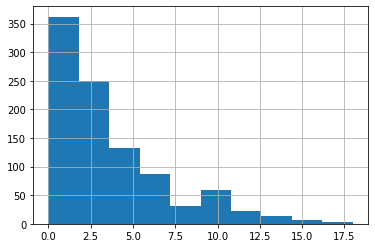

In [126]:
groupped_paris18.apply(get_len, axis = 1).hist()

### Smaller treshold for surface, higher on price

In [133]:
delta_price = 7
delta_surface = 2.5
delta_nbpiece = 1

groupped_montpellier = group_function(df_montpellier, delta_price, delta_surface, delta_piece)
groupped_paris18 = group_function(df_paris18, delta_price, delta_surface, delta_piece)
groupped_grenoble = group_function(df_grenoble, delta_price, delta_surface, delta_piece)

In [134]:
max(groupped_paris18.apply(get_len, axis = 1))

16

In [135]:
np.mean(groupped_paris18.apply(get_len, axis = 1))

2.4607438016528924

In [136]:
np.sum(groupped_paris18.apply(get_len, axis = 1) == 0)

292

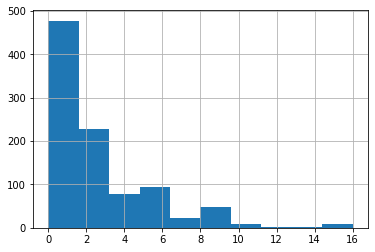

In [137]:
groupped_paris18.apply(get_len, axis = 1).hist()

### Smaller treshold for surface and on price

In [138]:
delta_price = 2.5
delta_surface = 2.5
delta_nbpiece = 1

groupped_montpellier = group_function(df_montpellier, delta_price, delta_surface, delta_piece)
groupped_paris18 = group_function(df_paris18, delta_price, delta_surface, delta_piece)
groupped_grenoble = group_function(df_grenoble, delta_price, delta_surface, delta_piece)

In [139]:
max(groupped_paris18.apply(get_len, axis = 1))

9

In [140]:
np.mean(groupped_paris18.apply(get_len, axis = 1))

1.0888429752066116

In [141]:
np.sum(groupped_paris18.apply(get_len, axis = 1) == 0)

491

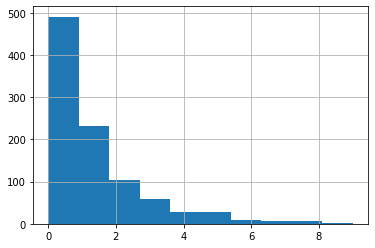

In [142]:
groupped_paris18.apply(get_len, axis = 1).hist()

In [143]:
delta_price = 3.5
delta_surface = 3
delta_nbpiece = 1

groupped_montpellier = group_function(df_montpellier, delta_price, delta_surface, delta_piece)
groupped_paris18 = group_function(df_paris18, delta_price, delta_surface, delta_piece)
groupped_grenoble = group_function(df_grenoble, delta_price, delta_surface, delta_piece)

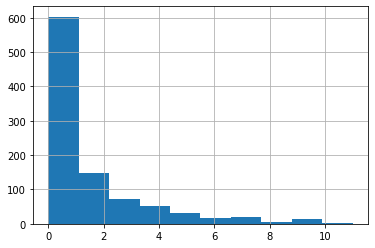

In [144]:
groupped_paris18.apply(get_len, axis = 1).hist()

In [145]:
np.sum(groupped_paris18.apply(get_len, axis = 1) == 0)

378

In [146]:
np.mean(groupped_paris18.apply(get_len, axis = 1))

1.6167355371900827

In [147]:
max(groupped_paris18.apply(get_len, axis = 1))

11

In [ ]:
import json
with open('/home/ubuntu/workspace/data/dedup_gold_set/idannonce_dedup.json', 'w') as handle:
    json.dump(list_ids_annotation, handle)

In [ ]:
groups_goldataset = pd.concat([groupped_grenoble, groupped_montpellier, groupped_paris18], sort=False)

In [ ]:
groupped_paris18.len_group.describe()

In [ ]:
groups_goldataset.len_group.describe()

In [ ]:
groups_goldataset.to_csv('/home/ubuntu/workspace/data/dedup_gold_set/goldset_dedup_grouped.csv', index=False)

In [ ]:
groupped_paris18.city_name.value_counts()

In [ ]:
190_000*1.05

# Check image access

In [ ]:
import json
with open('/home/ubuntu/workspace/data/dedup_gold_set/idannonce_dedup.json', 'r') as handle:
    selected_id_annonce = json.load(handle)

In [ ]:
import pandas as pd
id_photo = pd.read_excel('/home/ubuntu/workspace/data/dedup_gold_set/visuels_Nico.xlsx')

In [ ]:
id_photo

# Archives

In [ ]:
interest_column = ['surface','nb_pieces','nb_chambres','px','latitude','longitude']
# Select only columns of interest
df_montpellier_data = df_montpellier_blacklist[interest_column]
# Remove NaN
df_montpellier_data_no_nan = df_montpellier_data.dropna(axis=0)


In [ ]:
df_montpellier_data_no_nan

## Euclidian distance

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
euclidian_dist = euclidean_distances(df_montpellier_data_no_nan.values, df_montpellier_data_no_nan.values)
np.fill_diagonal(euclidian_dist, np.NaN)

## Check ads with a null distance for columns of interest

In [ ]:
# Get ads index for which there is a null euclidian distance
ad_index_1, ad_index_2 = np.where(euclidian_dist==0)

In [ ]:
# Index to Id Annonce
ad_id_1 = df_montpellier.loc[df_montpellier_data_no_nan.iloc[ad_index_1].index].idannonce
ad_id_2 = df_montpellier.loc[df_montpellier_data_no_nan.iloc[ad_index_2].index].idannonce

In [ ]:
similar_ads = np.array([ad_id_1, ad_id_2]).transpose()
df_similar_ads = pd.DataFrame(similar_ads)
df_similar_ads.columns = ['idannonce_1', 'idannonce_2']

In [ ]:
df_group_list = df_similar_ads.groupby('idannonce_1')['idannonce_2'].apply(list).reset_index()

In [ ]:
df_group_list['idannonce_1'] = df_group_list['idannonce_1'].apply(lambda x: [x])
df_group_list['combined'] = df_group_list.values.tolist()

In [ ]:
def ravel_list(l):
    return [item for sublist in l for item in sublist]
df_group_list['groups_similar'] = df_group_list['combined'].apply(ravel_list)
df_group_list['groups_size'] = df_group_list['groups_similar'].apply(lambda x: len(x))

In [ ]:
df_group_list[df_group_list['groups_size']>3][['groups_size']].describe()

In [ ]:
list_of_groups = df_group_list['groups_similar'] .values
list_of_groups

## Get groups of ID annonce

In [ ]:
df_groups = df_group_list.copy()[['groups_similar','groups_size']]
df_groups.groups_size.value_counts()

## Volume to export

In [ ]:
# CHeck Volume
minimum_number_in_group = 5 
nb_ads = df_groups[df_groups['groups_size']>=minimum_number_in_group].groups_size.sum()
print(f'{nb_ads}')
df_group_filtered = df_groups[df_groups['groups_size']>=minimum_number_in_group]

In [ ]:
# Get list of Id Annonce to export
list_idannonce = []
for index, row in df_group_filtered.iterrows():
    for idannonce in row['groups_similar']:
        list_idannonce.append([idannonce, index])
idannonce_table = np.array(list_idannonce)
idannonce_table

## Check some examples

In [ ]:
example = df_groups[df_groups['groups_size']>5].iloc[70]['groups_similar']
example

In [ ]:
df_montpellier[df_montpellier.idannonce.isin(example)].sort_values('dt_crea', ascending=False)

In [ ]:
a = []
for i in range(100):
    example = df_groups[df_groups['groups_size']>5].iloc[i]['groups_similar']
    ll = df_montpellier[df_montpellier.idannonce.isin(example)].sort_values('dt_crea', ascending=False)
    if ll['dt_crea'].iloc[0] > '2019-12-01':
        a.append(example)

In [ ]:
df_montpellier[df_montpellier.idannonce.isin(a[1])].sort_values('dt_crea', ascending=False)